##### Example taken from: 
https://www.kaggle.com/code/umongsain/vision-transformer-from-scratch-pytorch

In [34]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split,ConcatDataset
from torchvision.datasets import ImageFolder
from PIL import Image

### Dataset transformation

In [35]:
train_transform = tt.Compose([
    #tt.RandomHorizontalFlip(),
    #tt.RandomCrop(32,padding=4,padding_mode="reflect"),
    tt.ToTensor(),
    #tt.Normalize(*stats)
])

test_transform = tt.Compose([
    tt.ToTensor(),
    #tt.Normalize(*stats)
])

### Python datasets from folder
Directory specified as root
-root
    -test
    -train
        -classes
            -subclasses
                - * images

In [36]:
# PyTorch datasets
data_dir = r"/home/fberanek/Desktop/datasets/classification/cifar100"
train_data = ImageFolder(data_dir+'/train', train_transform)
test_data = ImageFolder(data_dir+'/test', test_transform)


### Display dataset
Here we can see, that images are already normalized ranging from 0 to 1

In [37]:
for image,label in train_data:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

print(f"labels {train_data.classes}")

Image shape:  torch.Size([3, 32, 32])
Image tensor:  tensor([[[0.6196, 0.6431, 0.6392,  ..., 0.5843, 0.5451, 0.4941],
         [0.6039, 0.6353, 0.6353,  ..., 0.5843, 0.5490, 0.4980],
         [0.6078, 0.6431, 0.6431,  ..., 0.5804, 0.5490, 0.5020],
         ...,
         [0.7059, 0.7216, 0.6863,  ..., 0.8549, 0.8471, 0.7961],
         [0.8902, 0.8667, 0.7804,  ..., 0.9569, 0.9647, 0.9451],
         [0.9804, 0.9647, 0.9098,  ..., 0.9843, 0.9843, 0.9451]],

        [[0.6314, 0.6745, 0.6863,  ..., 0.5804, 0.5490, 0.5137],
         [0.6275, 0.6824, 0.6902,  ..., 0.5922, 0.5647, 0.5294],
         [0.6353, 0.6902, 0.6980,  ..., 0.5961, 0.5765, 0.5333],
         ...,
         [0.7608, 0.7804, 0.7490,  ..., 0.8745, 0.8706, 0.8196],
         [0.9216, 0.9059, 0.8275,  ..., 0.9725, 0.9765, 0.9647],
         [0.9922, 0.9804, 0.9333,  ..., 0.9922, 0.9922, 0.9608]],

        [[0.3922, 0.3843, 0.3765,  ..., 0.3725, 0.3451, 0.3255],
         [0.3843, 0.3843, 0.3765,  ..., 0.3725, 0.3529, 0.3294],
     

### Get data loaders

In [38]:
BATCH_SIZE=1
train_dl = DataLoader(train_data,BATCH_SIZE,num_workers=4,pin_memory=True,shuffle=True)
test_dl = DataLoader(test_data,BATCH_SIZE,num_workers=4,pin_memory=True)

### Patchify image

In [39]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images
        
    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches

Here we can see decomposition of image into patches

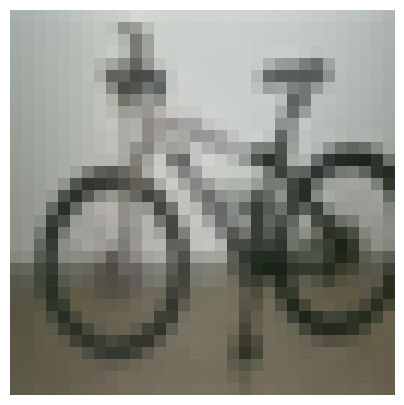

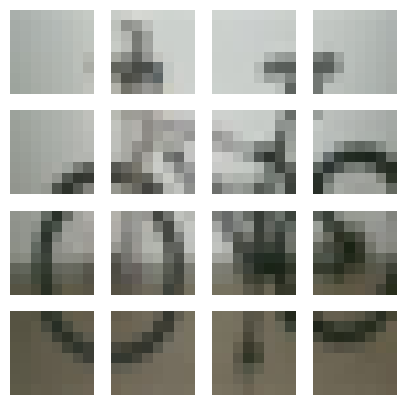

In [40]:
img, label = next(iter(train_dl))
batch_patches = patchify(img, (8,8))

img = img.movedim(1,-1)
plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap="gray")
plt.axis("off")

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape
batch_patches = batch_patches.movedim(1,-1)


plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(batch_patches[0, i, j], cmap="gray")
        plt.axis("off")

### Networks components

#### Firstly we define simple MLP
Multi-layer perceptron head, which is basically simple fully connected layer with x defined hidden layers

In [41]:
def get_mlp(in_features, 
            hidden_units, # As list of hidden features eg [128,64]
            out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1, dim2))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)

get_mlp(192,[128,64],28)

Sequential(
  (0): Linear(in_features=192, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=28, bias=True)
)

#### Image to sequence definition
Basically takes image, create patches and apply to each patch Linear layer </br>
<img src="images/patchifying.png"></br>
<i>https://arxiv.org/pdf/2105.01601.pdf</i></br>
We are also adding there positional encoding</br>
<img src="images/positional_encoding.png"></br>
<i>https://arxiv.org/pdf/1706.03762.pdf</i></br>
For the positional encoding, you can read this article: <i>https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6</i>

In [42]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences
    
    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model, sin_cos_position = True, verbose=True):
        super().__init__()
        #d_model: The number of features in the transformer encoder
        #patch_size: Size of the patch
        #n_channels: Number of image channels
        #img_size: Size of the image
        self.patch_size = patch_size
        self.img_size = img_size
        self.verbose = verbose
        self.sin_cos_position = sin_cos_position

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = (nh * nw) + 1 # +1 is for class token
        self.n_tokens = n_tokens
        self.verbose_results(f"Number of patches/tokens is {n_tokens}")

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.verbose_results(f"Token dimension is {token_dim}")

        # Our Linear layer to convert all patches into embeddings
        self.linear = nn.Linear(token_dim, d_model)
        # Cls token, that will be used as output for classification
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))

        # Is implementation of positional encoding correct ???????
        # Original article position encoding using sin/cod
        if self.sin_cos_position: 
            self.pos_emb = torch.randn(n_tokens, d_model)
            # Implemented according
            #https://medium.com/@hunter-j-phillips/multi-head-attention-7924371d477a
            for position in range(n_tokens):
                for i_dim in range(d_model//2):
                    self.pos_emb[position, 2*i_dim] = np.sin(position/(10000**(2*i_dim/d_model)))
                    self.pos_emb[position, 2*i_dim+1] = np.cos(position/(10000**(2*i_dim/d_model)))
        # Positional encoding using learnable layers
        else:
            self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))
            self.verbose_results(f"pos_emb dimension is {self.pos_emb.shape}")
        
    def verbose_results(self, to_print):
        if self.verbose:
            print(str(to_print))

    def __call__(self, batch):
        # Image has shape [1, 3, 32, 32] -> [batch, color channel, width, height]
        self.verbose_results(f"Shape before patchifying is {batch.shape}")
        # Create patche of image 
        # [1, 3, 4, 4, 8, 8] -> [batch, color channel, patch x, patch y, width, height]
        batch = patchify(batch, self.patch_size)
        # Shape after patchifying is: 
        self.verbose_results(f"Shape after patchifying is {batch.shape}")
        # Decompose batches
        b, c, nh, nw, ph, pw = batch.shape
        # Moving color channel at the end
        # Result shape is: [1, 4, 4, 8, 8, 3] -> [batch, patch x, patch y, width, height, color channel]
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        self.verbose_results(f"Shape after permutation is {batch.shape}")
        # Stack patches into one dimension and widthxheightxcolor channel into second
        # Result shape is: [1, 16, 192] -> [batch, patches, pixel values]
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])
        self.verbose_results(f"Shape after reshaping is {batch.shape}")
        # For each patch is apply same linear layer on all its features
        # Result shape is [1, 16, 512] -> [batch, patch, features]
        batch = self.linear(batch)
        self.verbose_results(f"Shape after linear is {batch.shape}")
        self.verbose_results(f"Pos_emb shape after linear is {batch.shape}")
        self.verbose_results(f"CLS shape after linear is {batch.shape}")
        # Append class patch, that is created in init as random parameter. Is this correct ?????
        # Result shape is [1, 17, 512] -> [batch, patch, features]
        cls = self.cls_token.expand([b, -1, -1])
        concatenated = torch.cat([cls, batch], axis=1)
        # Add positional encoding to the patches. 
        emb = concatenated + self.pos_emb
        self.verbose_results(f"Embeddings shape after is {emb.shape}")
        self.verbose_results(f"Concatenated shape after is {concatenated.shape}")
        return emb

##### Firstly visualize sinus/cosinus approach

In [43]:
img, label = next(iter(train_dl))

Number of patches/tokens is 17
Token dimension is 192
Shape before patchifying is torch.Size([1, 3, 32, 32])
Shape after patchifying is torch.Size([1, 3, 4, 4, 8, 8])
Shape after permutation is torch.Size([1, 4, 4, 8, 8, 3])
Shape after reshaping is torch.Size([1, 16, 192])
Shape after linear is torch.Size([1, 16, 512])
Pos_emb shape after linear is torch.Size([1, 16, 512])
CLS shape after linear is torch.Size([1, 16, 512])
Embeddings shape after is torch.Size([1, 17, 512])
Concatenated shape after is torch.Size([1, 17, 512])


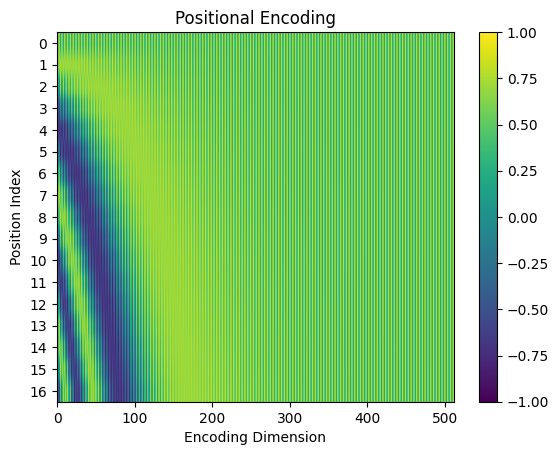

In [44]:
def visualize_pe(d_model):
  img2seq = Img2Seq(img.shape[2:], (8,8), 3, d_model, verbose=True)
  img2seq(img)
  plt.imshow(img2seq.pos_emb, aspect="auto")
  plt.title("Positional Encoding")
  plt.xlabel("Encoding Dimension")
  plt.ylabel("Position Index")

  # set the tick marks for the axes
  if d_model < 10:
    plt.xticks(torch.arange(0, d_model))
  if img2seq.n_tokens < 20:
    plt.yticks(torch.arange(img2seq.n_tokens-1, -1, -1))
    
  plt.colorbar()
  plt.show()


visualize_pe(512)

##### And visualize learnable parameter approach

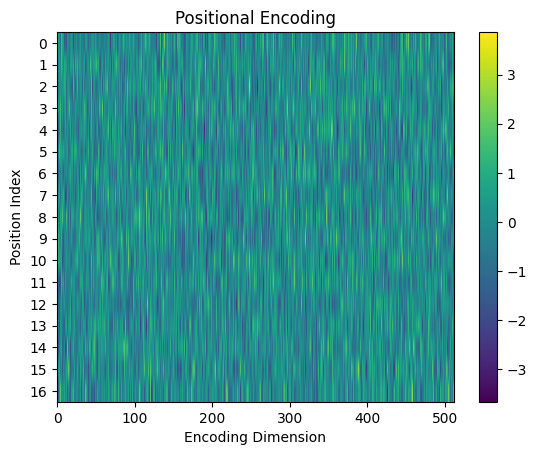

In [45]:
def visualize_pe(d_model):
  img2seq = Img2Seq(img.shape[2:], (8,8), 3, d_model, sin_cos_position=False,verbose=False)
  img2seq(img)
  plt.imshow(img2seq.pos_emb.detach().numpy(), aspect="auto")
  plt.title("Positional Encoding")
  plt.xlabel("Encoding Dimension")
  plt.ylabel("Position Index")

  # set the tick marks for the axes
  if d_model < 10:
    plt.xticks(torch.arange(0, d_model))
  if img2seq.n_tokens < 20:
    plt.yticks(torch.arange(img2seq.n_tokens-1, -1, -1))
    
  plt.colorbar()
  plt.show()


visualize_pe(512)

In [46]:
img2seq = Img2Seq(img.shape[2:], (8,8), 3, 512, verbose=False)
img_seq = img2seq(img)
img_seq.shape

torch.Size([1, 17, 512])

We have shape of (batch, 16 patches from image + 1 cls token for output classification, 512 features encoding)

#### Multi-head attention
Lets create multi-head attention </br>
<img src="images/multi_head_attention.png"></br>
You can read basics here: <i>https://medium.com/@ssrivastav_46455/unveiling-the-mathematics-behind-transformer-models-shaurya-srivastav-2fe1e47d20f9</i></br>
Or more detailed description in here:<i>https://medium.com/@hunter-j-phillips/multi-head-attention-7924371d477a</i>

In [47]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model: int = 512, n_heads: int = 8, dropout: float = 0.1):
    """
    Args:
        d_model:      dimension of embeddings
        n_heads:      number of self attention heads
        dropout:      probability of dropout occurring
    """
    super().__init__()
    assert d_model % n_heads == 0            # ensure an even num of heads
    self.d_model = d_model                   # 512 dim
    self.n_heads = n_heads                   # 8 heads
    self.d_key = d_model // n_heads          # assume d_value equals d_key | 512/8=64

    self.Wq = nn.Linear(d_model, d_model)    # query weights
    self.Wk = nn.Linear(d_model, d_model)    # key weights
    self.Wv = nn.Linear(d_model, d_model)    # value weights
    self.Wo = nn.Linear(d_model, d_model)    # output weights

    self.dropout = nn.Dropout(p=dropout)     # initialize dropout layer  

  def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
    """
    Args:
       query:         query vector         (batch_size, q_length, d_model), In our case its just X Embeddings
       key:           key vector           (batch_size, k_length, d_model), In our case its just X Embeddings
       value:         value vector         (batch_size, s_length, d_model), In our case its just X Embeddings
       mask:          mask for decoder     

    Returns:
       output:        attention values     (batch_size, q_length, d_model)
       attn_probs:    softmax scores       (batch_size, n_heads, q_length, k_length)
    """
    batch_size = x.size(0)                  
        
    # calculate query, key, and value tensors
    # This is part 1, where we create Query, Key, Values
    Q = self.Wq(x)                       # (1, 17, 512) x (512, 512) = (1, 17, 512)
    K = self.Wk(x)                       # (1, 17, 512) x (512, 512) = (1, 17, 512)
    V = self.Wv(x)                       # (1, 17, 512) x (512, 512) = (1, 17, 512)

    # split each tensor into n-heads to compute attention !!!!
    # As you see here, we tak original matrix and extend it by number of heads
    # query tensor
    Q = Q.view(batch_size,                   # (1, 17, 512) -> (1, 17, 8, 64) 
               -1,                           # -1 = q_length
               self.n_heads,              
               self.d_key
               ).permute(0, 2, 1, 3)         # (1, 17, 8, 64) -> (1, 8, 17, 64) = (batch_size, n_heads, q_length, d_key)
    # key tensor
    K = K.view(batch_size,                   # (1, 17, 512) -> (1, 17, 8, 64) 
               -1,                           # -1 = k_length
               self.n_heads,              
               self.d_key
               ).permute(0, 2, 1, 3)         # (1, 17, 8, 64) -> (1, 8, 17, 64) = (batch_size, n_heads, k_length, d_key)
    # value tensor
    V = V.view(batch_size,                   # (1, 17, 512) -> (1, 17, 8, 64) 
               -1,                           # -1 = v_length
               self.n_heads, 
               self.d_key
               ).permute(0, 2, 1, 3)         # (1, 17, 8, 64) -> (1, 8, 17, 64) = (batch_size, n_heads, v_length, d_key)
       
    # computes attention
    # scaled dot product -> QK^{T}
    scaled_dot_prod = torch.matmul(Q,        # (1, 8, 17, 64) x (1, 8, 64, 17) -> (1, 8, 17, 17) = (batch_size, n_heads, q_length, k_length)
                                   K.permute(0, 1, 3, 2)
                                   ) / math.sqrt(self.d_key)      # sqrt(64)
        
    # fill those positions of product as (-1e10) where mask positions are 0
    if mask is not None:
      scaled_dot_prod = scaled_dot_prod.masked_fill(mask == 0, -1e10)

    # apply softmax 
    attn_probs = torch.softmax(scaled_dot_prod, dim=-1)
    
    # multiply by values to get attention
    A = torch.matmul(self.dropout(attn_probs), V)       # (1, 8, 17, 17) x (1, 8, 17, 64) -> (1, 8, 17, 64)
                                                        # (batch_size, n_heads, q_length, k_length) x (batch_size, n_heads, v_length, d_key) -> (batch_size, n_heads, q_length, d_key)
    
    # reshape attention back to (1, 17, 512)
    # Here we only move axis with head onto to third place
    A = A.permute(0, 2, 1, 3).contiguous()              # (1, 8, 17, 64) -> (1, 17, 8, 64)
    # And squeeze one two axis into one
    A = A.view(batch_size, -1, self.n_heads*self.d_key) # (1, 17, 8, 64) -> (1, 17, 8*64) -> (1, 17, 512) = (batch_size, q_length, d_model)
    # And we have same shape as before

    # push through the final weight layer
    output = self.Wo(A)                                 # (32, 10, 512) x (512, 512) = (32, 10, 512) 

    return output, attn_probs                           # return attn_probs for visualization of the scores

In [48]:
MHA = MultiHeadAttention(d_model = 512, 
                         n_heads = 8,
                         dropout = 0.1)
output, attn_probs = MHA.forward(img_seq)
attn_probs.shape

torch.Size([1, 8, 17, 17])

In [49]:
output.shape

torch.Size([1, 17, 512])

#### VIT model

In [71]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward, 
        mlp_head_units,
        n_classes,
        batch_size
    ):
        super().__init__()
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        num_of_patches = int(img_size[0]*img_size[1]/patch_size[0]/patch_size[1]+1)
        # Get image sequencing
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model,verbose=False)
        # Get multi head attention
        self.multihead = MultiHeadAttention(d_model,nhead,0.1)
        # Get feed forwad that will be used for Multi-Head Attention
        self.mlp = get_mlp(d_model,mlp_head_units,d_model)
        # Get Multi-head Attention
        self.after_mlp_head = get_mlp(d_model,mlp_head_units,dim_feedforward)
        # Output layer
        self.output_mlp = get_mlp(dim_feedforward,mlp_head_units,n_classes)
        # Layer norm 
        self.norm_after_multi_hear = torch.nn.LayerNorm((batch_size,num_of_patches,d_model))
        self.norm_2 = torch.nn.LayerNorm((batch_size,num_of_patches,d_model))
        """
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)
        
        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()
        """

    def __call__(self, batch):
        # Create embedding as patches + cls token with added position encoding feeded into fully connected
        # According first part of https://arxiv.org/pdf/2105.01601.pdf
        # And Positional aencoding according https://arxiv.org/pdf/1706.03762.pdf
        batch = self.img2seq(batch)
        # Run Multi-Head Attentnion according https://medium.com/@hunter-j-phillips/multi-head-attention-7924371d477a
        multihead_batch, attn_probs = self.multihead(batch)
        # Add Embeddings to the ooutputs of Multi-Head Attention and normalize
        batch = self.norm_after_multi_hear(batch+multihead_batch)
        # Run feed forward
        batch_linearized = self.mlp(batch)
        # Add output before feed forward to results after last normlization and normalize
        batch = self.norm_2(batch+batch_linearized)
        # Select cls token
        batch = batch[:, 0, :]
        # Run one extended feed forward
        batch = self.after_mlp_head(batch)
        # Run last feed forward to get class
        batch = self.output_mlp(batch)
        return batch

In [72]:
img_size = (32, 32)
patch_size = (8, 8)
n_channels = 3
d_model = 512
nhead = 8
dim_feedforward = 1024
blocks = 8
mlp_head_units = [1024, 512]
n_classes = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [73]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()


net = ViT(img_size, 
          patch_size, 
          n_channels, 
          d_model,
          nhead, 
          dim_feedforward, 
          mlp_head_units, 
          len(train_data.classes), 
          BATCH_SIZE)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [74]:
train_data.classes

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

In [75]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1024 and 512x1024)

In [76]:
outputs.shape

NameError: name 'outputs' is not defined